In [472]:
'''Importing basic data analysis packages'''
import numpy as np
import pandas as pd
import csv
import warnings
import os
import time
warnings.filterwarnings('ignore')
os.getcwd()

'''Plotting packages'''
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.3)

p1 = pd.read_csv('p1.csv')
print('PLEDGE 1% cols: {}\nSHAPE: {}\n'.format(p1.columns.to_list(), p1.shape))

#################
# Organizations #
#################
print('*'*100)

ppl = pd.read_csv('people.csv')
print('PEOPLE cols: {}\nSHAPE: {}\n'.format(ppl.columns.to_list(), ppl.shape))

jobs = pd.read_csv('jobs.csv') # All jobs affiliated with company
print('JOBS cols: {}\nSHAPE: {}'.format(jobs.columns.to_list(), jobs.shape))

funds = pd.read_csv('funds.csv')
print('JOBS cols: {}\nSHAPE: {}'.format(funds.columns.to_list(), funds.shape))

org = pd.read_csv('organizations.csv')
print('ORGANIZATION/org cols: {}\nSHAPE: {}\n'.format(org.columns.to_list(), org.shape))

invest = pd.read_csv('investments.csv')
print('INVESTMENTS/invest cols: {}\nSHAPE: {}\n'.format(invest.columns.to_list(), invest.shape))

fund_rnds = pd.read_csv('funding_rounds.csv')
print('FUNDING ROUNDS/fund_rnds cols: {}\nSHAPE: {}\n'.format(fund_rnds.columns.to_list(), fund_rnds.shape))

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

PLEDGE 1% cols: ['uuid', 'p1_tag', 'p1_date']
SHAPE: (7822, 3)

****************************************************************************************************
PEOPLE cols: ['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at', 'updated_at', 'first_name', 'last_name', 'gender', 'country_code', 'state_code', 'region', 'city', 'featured_job_organization_uuid', 'featured_job_organization_name', 'featured_job_title', 'facebook_url', 'linkedin_url', 'twitter_url', 'logo_url']
SHAPE: (1055813, 22)

JOBS cols: ['job_uuid', 'person_uuid', 'person_name', 'org_uuid', 'org_name', 'started_on', 'ended_on', 'is_current', 'title', 'job_type', 'p1_tag', 'p1_date']
SHAPE: (1536376, 12)
JOBS cols: ['uuid', 'name', 'type', 'permalink', 'cb_url', 'rank', 'created_at', 'updated_at', 'entity_uuid', 'entity_name', 'entity_type', 'announced_on', 'raised_amount_usd', 'raised_amount', 'raised_amount_currency_code']
SHAPE: (15560, 15)
ORGANIZATION/org cols: ['uuid', 'name', 'type', 'permalin

In [473]:
# merge org and p1 datasets 
df_org = pd.merge(org.copy(),p1.copy(),how='inner',on='uuid')

df_org['p1_tag'] = df_org['p1_tag'].apply(lambda x: 1 if x == True else 0)
df_org['employee_count'] = df_org['employee_count'].apply(lambda x: np.NaN if x == 'unknown' else x)
df_org = df_org[['uuid','name','rank','status','p1_date','total_funding_usd','p1_tag']]

In [474]:
# filter p1 companies 
df_org = reduce_mem_usage(df_org)
df_org = df_org[df_org['p1_tag'] == 1].sort_values('p1_date')

Mem. usage decreased to  0.37 Mb (23.4% reduction)


In [475]:
# join org and funding_rounds to get funding_rounds info for a particular organization
df_org['org_uuid'] = df_org['uuid']
df_org = pd.merge(df_org.copy(),fund_rnds.copy(),on='org_uuid')

In [476]:
# pick only investors who are people from invest dataset
df_invest = invest[invest['investor_type'] == 'person']

In [477]:
df_invest.columns

Index(['investment_uuid', 'funding_round_uuid', 'investor_uuid',
       'investor_name', 'investor_type', 'is_lead_investor', 'investment_type',
       'announced_on', 'raised_amount_usd', 'post_money_valuation_usd',
       'investor_count', 'lead_investor_uuids', 'lead_investor_count',
       'org_uuid', 'org_name', 'p1_tag', 'p1_date'],
      dtype='object')

In [478]:
# reduce memory
df_org = reduce_mem_usage(df_org)

# select needed attributes from df_org
df_org = df_org[['funding_round_uuid','org_uuid','name','investment_type',
                'rank','status','p1_date_x','total_funding_usd', \
                         'p1_tag_x','raised_amount_usd','post_money_valuation_usd', \
                       'lead_investor_uuids','investor_count']]
 
print(df_org.shape)

# merge df_org with invest dataset on funding_round_uuid
df_org = pd.merge(df_invest.copy(),df_org.copy(),on='funding_round_uuid')
df_org = reduce_mem_usage(df_org)


# if a lead investor add 1 else 0
df_org.loc[df_org['is_lead_investor'] == True, 'lead_count'] = 1 
df_org.loc[df_org['is_lead_investor'] != True, 'lead_count'] = 0

# filter the records that do not have a matching funding_round_uuid
df_org = df_org[~df_org['funding_round_uuid'].isna()].sort_values('p1_date_x')

Mem. usage decreased to  0.83 Mb (17.9% reduction)
(7353, 13)
Mem. usage decreased to  0.42 Mb (12.3% reduction)


In [479]:
# create a new dataframe for top 100 people grouped on investor_name by aggregating funding_round_uuid as count of presence in funding rounds
# lead_count as sum of lead_count occurences

df_p1_100 = df_org.groupby('investor_name',as_index=False).agg({"funding_round_uuid":"count","lead_count":"sum"}).\
sort_values('funding_round_uuid',ascending=False)[0:100]
#df_p1_100.head()


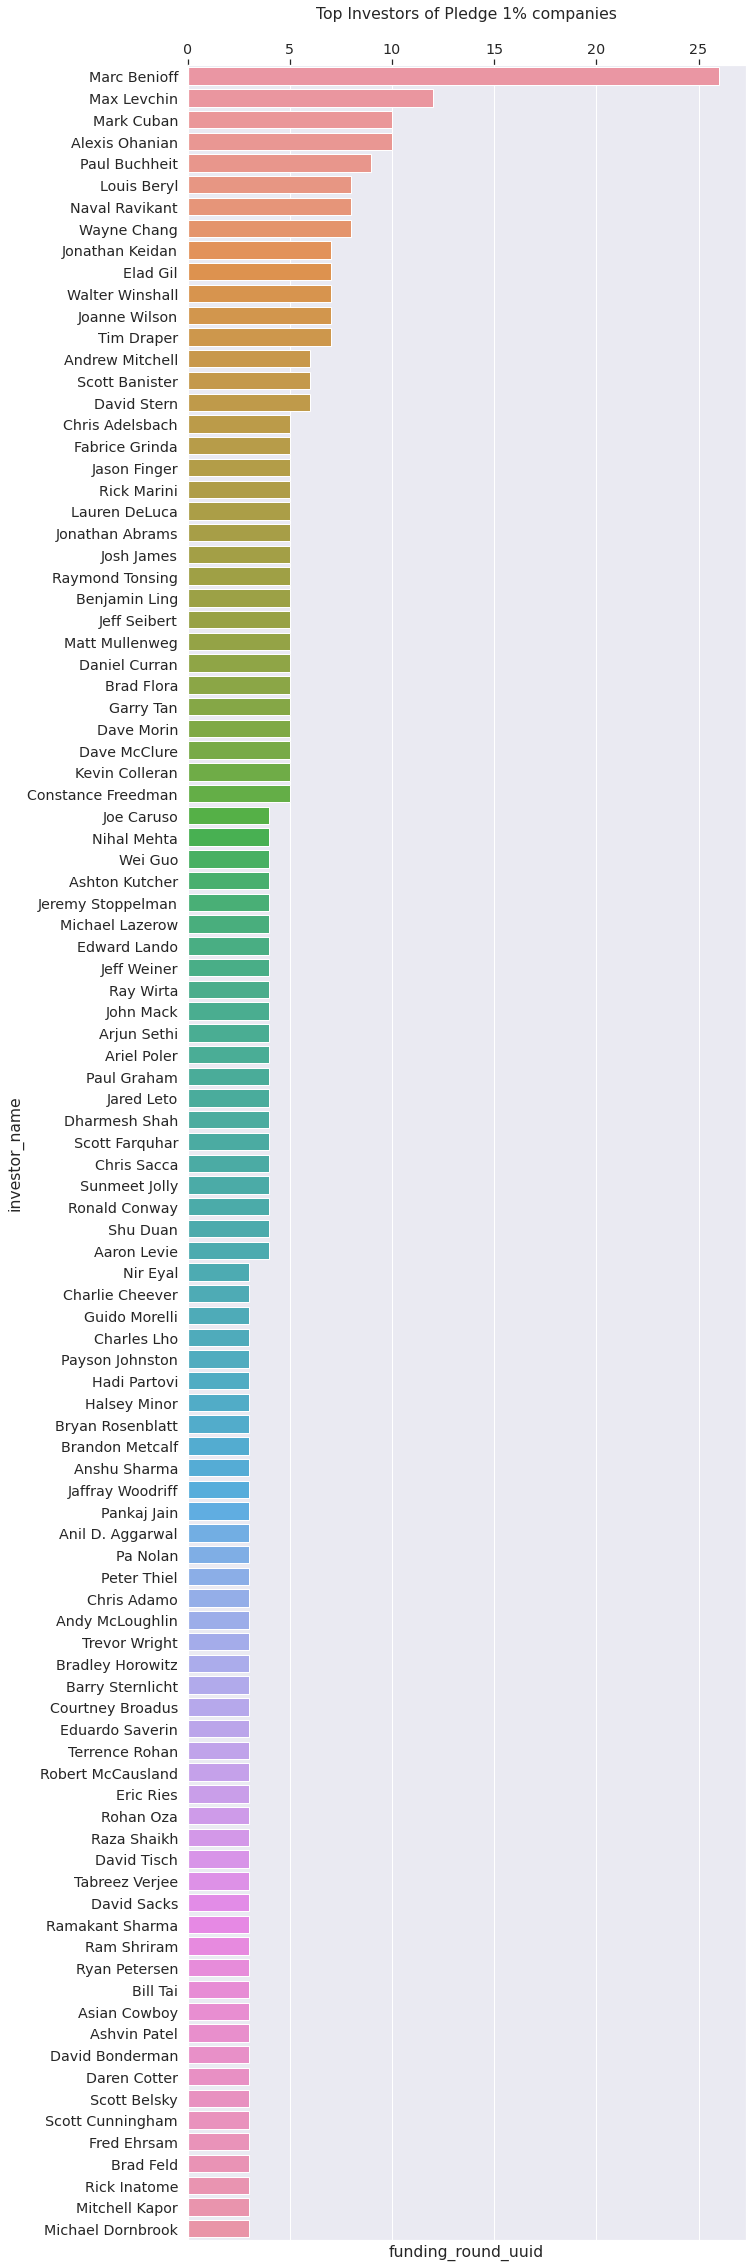

In [480]:
# Plot the graphs
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.backends.backend_pdf import PdfPages

_, ax = plt.subplots(figsize=(10,40), sharey=True)

# p1 investors plot
ax.ticklabel_format(useOffset=False, style='plain')

ax.set_title('Top Investors of Pledge 1% companies\n')
ax.xaxis.set_ticks_position("top")
sns.barplot(x='funding_round_uuid', y='investor_name', data=df_p1_100, orient='h', ax=ax)

# save the figure
_.savefig("Top_Investing_people_p1_by_counts.pdf", bbox_inches='tight')

In [482]:
# now create a dataframe for all people similar to df_p1_100
df_p1_all = df_org.groupby(['investor_name','investor_uuid'],as_index=False).agg({"funding_round_uuid":"count","lead_count":"sum"}).\
sort_values('funding_round_uuid',ascending=False)

In [483]:
# merge the above ppl_in_p1 dataset with jobs dataset to get the jobs information for all the people in ppl_in_p1 dataset
investor['investor_uuid'] = investor['uuid']
df_p1_all = pd.merge(df_p1_all.copy(),investor.copy(),how='inner',on=['investor_uuid'])

df_p1_all = df_p1_all[['investor_name', 'investor_uuid', 'funding_round_uuid', 'lead_count','permalink']]

# create a list of all people from df_p1_all
list_df_p1_all = list(df_p1_all['investor_uuid'])

# select all the records for the people list from ppl dataset
ppl_in_p1 = ppl.loc[ppl['uuid'].isin(list_df_p1_all)]

In [484]:
# merge the above ppl_in_p1 dataset with jobs dataset to get the jobs information for all the people in ppl_in_p1 dataset
ppl_in_p1['person_uuid'] = ppl_in_p1['uuid']
df_ppl_in_p1_j = pd.merge(ppl_in_p1.copy(),jobs.copy(),how='inner',on=['person_uuid'])
#df_ppl_in_p1_j.loc[df_ppl_in_p1_j['name'].isin(['Steve Chen'])]

In [485]:
# only keep the needed attributes person_name and featured_job_organization_uuid
df_ppl_in_p1_j = df_ppl_in_p1_j[['person_name','person_uuid','featured_job_organization_uuid']]

In [486]:
# remove any duplicates if present
df_ppl_in_p1_j = df_ppl_in_p1_j.drop_duplicates()
#df_ppl_in_p1_j.head()

In [495]:
# merge the above dataset with funds dataset on featured_job_organization_uuid
funds['featured_job_organization_uuid'] = funds['entity_uuid']
df_ppl_in_p1_j_o = pd.merge(df_ppl_in_p1_j.copy(),funds.copy(),how='outer',on='featured_job_organization_uuid')

In [496]:
# drop any duplicates if present
df_ppl_in_p1_j_o = df_ppl_in_p1_j_o.drop_duplicates()

In [497]:
df_ppl_in_p1_j_o['entity_name'].fillna('Not Available', inplace=True)
df_ppl_in_p1_j_o['raised_amount_usd'].fillna(0, inplace=True)

#df_ppl_in_p1_j_o.loc[df_ppl_in_p1_j_o['person_name'].isin(['Steve Chen'])]

In [498]:
# From the above groupby person_name, entity_name and aggregate raised_amount_usd and sort by raised amount usd
# This result below shows the entity associated with a person and the total amount raised by that entity

df_ppl_in_p1_j_o_g = df_ppl_in_p1_j_o.groupby(['person_name','person_uuid','entity_name'],as_index=False).agg({"raised_amount_usd":"sum"}).\
sort_values('raised_amount_usd',ascending=False)
df_ppl_in_p1_j_o_g.head(4) 

,person_name,person_uuid,entity_name,raised_amount_usd
370,Deep Nishar,3f39d9c0-bd96-2cce-4756-20ce010799ac,SoftBank Vision Fund,2.080000e+11
1254,Shankar Narayanan,cb893e09-0b80-481c-e4c7-a0fe883016ef,The Carlyle Group,1.100283e+11
545,Henrik Kraft,250067b8-71c9-1ee1-4385-2f5bd86080c3,Kohlberg Kravis Roberts,6.392711e+10
1050,Paul Raether,7a3beec1-dc8e-3d9a-3746-d3257242a88a,Kohlberg Kravis Roberts,6.392711e+10


In [499]:
df_ppl_in_p1_j_o_g.loc[df_ppl_in_p1_j_o_g['person_name'].isin(['Steve Chen'])]

,person_name,person_uuid,entity_name,raised_amount_usd
1309,Steve Chen,a04640c3-cdd9-32de-04cb-fa19539872bf,GV,100000000.0
1308,Steve Chen,412482ce-1844-ddce-f874-89258b9c475c,Not Available,0.0


In [500]:
df_p1_all.loc[df_p1_all['investor_name'].isin(['Steve Chen'])]

,investor_name,investor_uuid,funding_round_uuid,lead_count,permalink
604,Steve Chen,412482ce-1844-ddce-f874-89258b9c475c,1,0.0,steve-chen-3
650,Steve Chen,a04640c3-cdd9-32de-04cb-fa19539872bf,1,0.0,steve-chen


In [501]:
# finally merge above set with df_p1_all to get the below
# person_name, entity where person worked, amount raised by that entity, total funding rounds for that person and lead_count for that
# person
df_p1_all['person_uuid'] = df_p1_all['investor_uuid']
df_p1_all['person_name'] = df_p1_all['investor_name']
df_ppl_in_p1_j_o_g_all = pd.merge(df_ppl_in_p1_j_o_g.copy(),df_p1_all.copy(),how='inner',on=['person_name','person_uuid'])

In [502]:
df_ppl_in_p1_j_o_g_all.loc[df_ppl_in_p1_j_o_g_all['investor_name'].isin(['Steve Chen'])]

,person_name,person_uuid,entity_name,raised_amount_usd,investor_name,investor_uuid,funding_round_uuid,lead_count,permalink
191,Steve Chen,a04640c3-cdd9-32de-04cb-fa19539872bf,GV,100000000.0,Steve Chen,a04640c3-cdd9-32de-04cb-fa19539872bf,1,0.0,steve-chen
630,Steve Chen,412482ce-1844-ddce-f874-89258b9c475c,Not Available,0.0,Steve Chen,412482ce-1844-ddce-f874-89258b9c475c,1,0.0,steve-chen-3


In [503]:
# drop duplicates and order by funding_round_uuid
df_ppl_in_p1_j_o_g_all = df_ppl_in_p1_j_o_g_all.drop_duplicates().sort_values('funding_round_uuid',ascending=False)
df_ppl_in_p1_j_o_g_all.head(1)

,person_name,person_uuid,entity_name,raised_amount_usd,investor_name,investor_uuid,funding_round_uuid,lead_count,permalink
188,Marc Benioff,61d19fc5-3a69-e4f7-9a6d-83d4fb6a0212,Salesforce,100000000.0,Marc Benioff,61d19fc5-3a69-e4f7-9a6d-83d4fb6a0212,26,1.0,marc-benioff


In [504]:
# select the needed records and sort by raised amount and write the output to file
df_ppl_in_p1_j_o_g_all = df_ppl_in_p1_j_o_g_all[['person_name','person_uuid','entity_name','raised_amount_usd','funding_round_uuid','lead_count']]
df_ppl_in_p1_j_o_g_all = df_ppl_in_p1_j_o_g_all.rename(columns={"raised_amount_usd": "entity_raised_amt_usd"}).\
sort_values(['funding_round_uuid','lead_count','entity_raised_amt_usd'],ascending=False)
df_ppl_in_p1_j_o_g_all.to_csv('Top_Investing_people_test.csv')